In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%watermark -v -p numpy,pandas,matplotlib,sklearn,torch,torchvision,pytorch_lightning

CPython 3.6.9
IPython 7.16.1

numpy 1.18.5
pandas 1.0.4
matplotlib 3.2.1
sklearn 0.23.1
torch 1.6.0.dev20200609+cu101
torchvision 0.7.0.dev20200609+cu101
pytorch_lightning 0.8.5


In [2]:
from k12libs.utils.nb_easy import k12ai_train_execute
from k12libs.utils.nb_easy import k12ai_get_data, k12ai_get_top_dir
from k12libs.utils.nb_easy import k12ai_print, k12ai_set_notebook
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# pd.options.display.max_rows=None
# pd.options.display.max_columns=None

k12ai_set_notebook(cellw=90)

In [3]:
backbones = [
    'resnet18',          # 0 
    'densenet121',       # 1
    'mobilenet_v2',      # 2 
    'squeezenet1_0',     # 3
    'squeezenet1_1',     # 4
    'shufflenet_v2_x0_5',# 5
    'shufflenet_v2_x1_0',# 6
]
datasets = ['rmnist', 'rchestxray', 'rDogsVsCats']
batch_sizes = [32]
input_sizes = [128]
epoch_num = 20
test_iters = 24

## 统计

In [4]:
def acc_stat(dataset):
    max_try = 3600
    for net in backbones:
        for bs in batch_sizes:
            for ss in input_sizes:
                stats = []
                recfile = os.path.join(k12ai_get_top_dir(), 'assets/acc_stats', f'{dataset}-{net}-{bs}-{ss}.json')
                if os.path.exists(recfile):
                    print(f'{recfile} is already exist!')
                    continue
                print(dataset, net, bs, ss)
                trycnt = max_try
                keys = k12ai_train_execute(
                    framework='k12cv', task='cls',
                    network=net, dataset=dataset,
                    batchsize=bs, inputsize=ss, epoch_num=epoch_num, test_iters=test_iters, run_num=1)
                while trycnt > 0:
                    data = k12ai_get_data(keys[0], 'metrics', num=1, rm=True)
                    # metrics
                    if data:
                        try:
                            metrics = data[0]['value']
                            if isinstance(metrics['data'], (list, tuple)) and len(metrics['data']) > 0:
                                for item in metrics['data']:
                                    if item['type'] == 'scalar':
                                        if 'acc' in item['data']['title']:
                                            stats.append(metrics)
                        except Exception as err:
                            print(err, keys[0])
                    data = k12ai_get_data(keys[0], 'error', num=1, rm=True)
                    # status
                    if data:
                        try:
                            result = data[0]['value']
                            code = result['data']['code']
                            if code == 100004 or code > 100100: # stop or error
                                break
                            elif code == 100003: # finish
                                break
                        except Exception as err:
                            print(err, keys[0])
                    trycnt -= 1
                with open(recfile, 'w') as f:
                    json.dump(stats, f)

In [5]:
for dataset in datasets:
    acc_stat(dataset)

/hzcsk12/hzcsnote/assets/acc_stats/rmnist-resnet18-32-128.json is already exist!
/hzcsk12/hzcsnote/assets/acc_stats/rmnist-densenet121-32-128.json is already exist!
/hzcsk12/hzcsnote/assets/acc_stats/rmnist-mobilenet_v2-32-128.json is already exist!
/hzcsk12/hzcsnote/assets/acc_stats/rmnist-squeezenet1_0-32-128.json is already exist!
/hzcsk12/hzcsnote/assets/acc_stats/rmnist-squeezenet1_1-32-128.json is already exist!
/hzcsk12/hzcsnote/assets/acc_stats/rmnist-shufflenet_v2_x0_5-32-128.json is already exist!
/hzcsk12/hzcsnote/assets/acc_stats/rmnist-shufflenet_v2_x1_0-32-128.json is already exist!
/hzcsk12/hzcsnote/assets/acc_stats/rchestxray-resnet18-32-128.json is already exist!
/hzcsk12/hzcsnote/assets/acc_stats/rchestxray-densenet121-32-128.json is already exist!
/hzcsk12/hzcsnote/assets/acc_stats/rchestxray-mobilenet_v2-32-128.json is already exist!
/hzcsk12/hzcsnote/assets/acc_stats/rchestxray-squeezenet1_0-32-128.json is already exist!
/hzcsk12/hzcsnote/assets/acc_stats/rchestxra

## 分析

### 加载

In [6]:
root_path = os.path.join(k12ai_get_top_dir(), 'assets/acc_stats')
items = []
for entry in os.scandir(root_path):
    filename = entry.name[:-5]
    [dataset_name, model_name, batch_size, input_size] = filename.split('-')
    with open(entry.path, 'r') as f:
        iterations, losses, acces = [], [], []
        for el in json.load(f):
            for mm in el['data']:
                if 'scalar' != mm['type']:
                    continue
                data = mm['data']
                if 'train_val_loss' in data['title']:
                    losses.append(round(data['payload']['y'][1]['value'], 3)) # val loss
                if 'val_acc' in data['title']:
                    iterations.append(data['payload']['x']['value'])
                    acces.append(round(data['payload']['y'][0]['value'], 3)) # top1
        items.append({
            'dataset_name': dataset_name,
            'model_name': model_name,
            'batch_size': int(batch_size),
            'input_size': int(input_size),
            'iteration': iterations,
            'acc': acces
        })

In [7]:
gdf = pd.DataFrame(items)
gdf[:10]

,dataset_name,model_name,batch_size,input_size,iteration,acc
0,rchestxray,squeezenet1_1,32,128,"[24, 48, 72, 96, 120, 144, 160]","[0.733, 0.95, 0.933, 0.917, 0.967, 0.967, 0.967]"
1,rDogsVsCats,squeezenet1_1,32,128,"[24, 48, 72, 96, 120, 144, 168, 192, 240, 264,...","[0.495, 0.495, 0.495, 0.495, 0.495, 0.495, 0.4..."
2,rchestxray,shufflenet_v2_x0_5,32,128,"[24, 48, 72, 96, 120, 144, 160]","[0.5, 0.483, 0.75, 0.85, 0.833, 0.833, 0.85]"
3,rDogsVsCats,mobilenet_v2,32,128,"[48, 72, 96, 168, 192, 216, 240, 264, 288, 336...","[0.495, 0.495, 0.512, 0.608, 0.592, 0.613, 0.5..."
4,rmnist,mobilenet_v2,32,128,"[24, 48, 72, 96, 144, 168, 192, 216, 264, 288,...","[0.101, 0.134, 0.666, 0.666, 0.82, 0.652, 0.76..."
5,rmnist,densenet121,32,128,"[24, 48, 72, 96, 120, 144, 168, 192, 216, 240,...","[0.107, 0.144, 0.113, 0.114, 0.352, 0.116, 0.7..."
6,rchestxray,densenet121,32,128,"[24, 48, 72, 96, 120, 144, 160]","[0.967, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
7,rmnist,shufflenet_v2_x0_5,32,128,"[24, 48, 72, 96, 120, 144, 168, 192, 216, 240,...","[0.091, 0.511, 0.679, 0.782, 0.787, 0.869, 0.8..."
8,rDogsVsCats,shufflenet_v2_x0_5,32,128,"[48, 72, 96, 144, 168, 192, 240, 264, 288, 312...","[0.517, 0.556, 0.503, 0.605, 0.602, 0.609, 0.6..."
9,rchestxray,mobilenet_v2,32,128,"[24, 48, 72, 96, 120, 144, 160]","[0.5, 0.5, 0.5, 0.85, 0.9, 0.95, 0.917]"


### 绘制

In [29]:
def plot_acc(gdf, dataset):
    fig = plt.figure(figsize=(12,8))
    plt.ylim(0.1, 1.1)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    
    df = gdf[gdf['dataset_name'] == dataset]
    batch_size = None
    input_size = None
    for i in range(len(df)):
        row = df.iloc[i]
        if batch_size is None:
            batch_size = row['batch_size'] 
        if input_size is None:
            input_size = row['input_size'] 
        xs, ys = np.array(row['iteration']), np.array(row['acc'])
        if len(xs) < 200:
            ts = np.linspace(xs.min(), xs.max(), 100)
            ys = make_interp_spline(xs, ys)(ts)
            xs = ts
        plt.plot(xs, ys, label=row['model_name'], linewidth=3)

        xmin, xmax = plt.xlim()
    plt.hlines(y=0.8, xmin=xmin, xmax=xmax, color='red', linestyles='--')
    plt.legend(loc='lower right')
    plt.title(f'{dataset}-{batch_size}-{input_size}')

#### 数据集:rchestxray

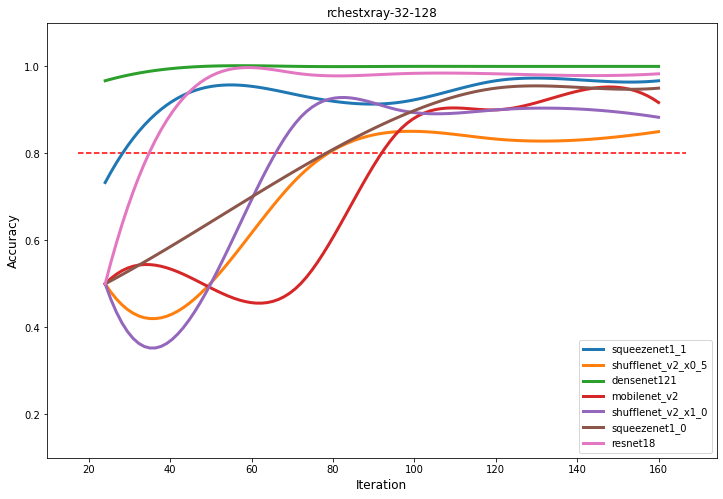

In [26]:
plot_acc(gdf, 'rchestxray')

#### 数据集:rDogsVsCats

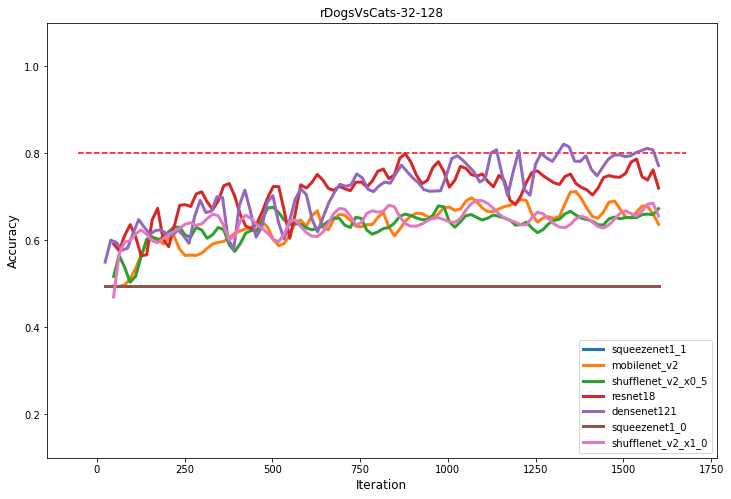

In [27]:
plot_acc(gdf, 'rDogsVsCats')

#### 数据集:xmnist

154
167
158
154
150
157
0


ValueError: zero-size array to reduction operation minimum which has no identity

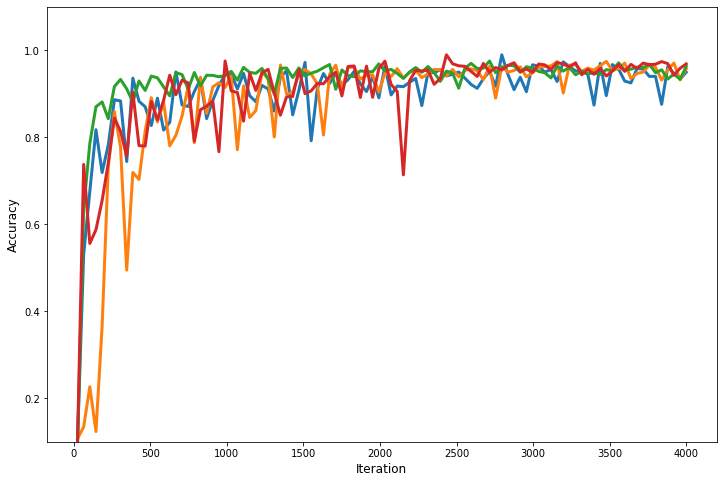

In [30]:
plot_acc(gdf, 'rmnist')